# Preparation

Planning - Acquisition - **Preparation** - Exploratory Analysis - Modeling - Product Delivery

**Goal:** Prepare, tidy, and clean the data so that it is ready for exploration and analysis.  

**Input:** 1 or more dataframes acquired through the "acquire" step.  

**Output:** 1 dataset split into 3 samples in the form of dataframes: train, validate & test. 

**Artifact:** prepare.py


## Overview

1. Summarize our data:

    - head(), describe(), info(), isnull(), value_counts(), shape, ...  
    - plt.hist(), plt.boxplot()  
    - document takeaways (nulls, datatypes to change, outliers, ideas for features, etc.)  


2. Clean the data:

    - missing values: drop columns with too many missing values, drop rows with too many missing values, fill with zero where it makes sense, and then make note of any columns you want to impute missing values in (you will need to do that on split data). 
    - **outlier**: an observation point that is distant from other observations	https://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/
    - outliers: ignore, drop rows, snap to a selected max/min value, create bins (cut, qcut) 
    - data errors: drop the rows/observations with the errors, correct them to what it was intended  
    - address text normalization issues...e.g. deck 'C' 'c'. (correct and standardize the text)
    - tidy data: getting your data in the shape it needs to be for modeling and exploring. every row should be an observation and every column should be a feature/attribute/variable. You want 1 observation per row, and 1 row per observation. If you want to predict a customer churn, each row should be a customer and each customer should be on only 1 row. (address duplicates, aggregate, melt, reshape, ...)   
    - creating new variables out of existing variables (e.g. z = x - y) 
    - rename columns  
    - datatypes: need numeric data to be able to feed into model (dummy vars, factor vars, manual encoding)  
    - scale numeric data: so that continuous variables have the same weight, are on the same units, if algorithm will be used that will be affected by the differing weights, or if data needs to be scaled to a gaussian/normal distribution for statistical testing. (linear scalers and non-linear scalers)  


3. Split the data:

    - split our data into train, validate and test sample dataframes  
    - Why? overfitting: model is not generalizable. It fits the data you've trained it on "too well". 3 points does not necessarily mean a parabola.  
    - **train:** *in-sample*, explore, impute mean, scale numeric data (max() - min()...), fit our ml algorithms, test our models. 
    - **validate, test**: represents future, unseen data  
    - **validate**: confirm our top models have not overfit, test our top n models on unseen data. Using validate performance results, we pick the top **1** model.   
    - **test**: *out-of-sample*, how we expect our top model to perform in production, on unseen data in the future. **ONLY USED ON 1 MODEL.**  
    - You want to do all the prep that can be done on the full dataset before you split. Go through, work on DF for all you need to, then move to train when it's time. So you don't have to go back and forth, because leads to errors and inconsistencies in data. 

!!!note "algorithm vs. model"
    - **algorithm:** the method that sklearn provides, such as decision_tree, knn, ..., y = mx+b
    - **model:** that algorithm specific to our data, e.g. regression: the model would contain the slope value and intercept value. y = .2x+5

!!!note "Should I do *this* on the full dataset or on the train sample?"
    *this*: the action, method, function, step you are about to take on your data.    

    1. Are you comparing, looking at the relationship or summary stats or visualizations with 2+ variables?
    2. Are you using an sklearn method?
    3. Are you moving into the explore stage of the pipeline?

    If **ONE** or more of these is yes, then you should be doing it on your train sample.
    If **ALL** are no, then the entire dataset is fine.

## Summarize the Acquired Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

# import our own acquire module
import acquire

We'll use the funciton we defined in the last lesson to acquire our data:

In [2]:
df = acquire.get_titanic_data()

In [3]:
# rows & columns

df.shape

(891, 13)

In [4]:
# first n rows

df.head(2)

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0


In [5]:
# Get information about the dataframe: column names, rows, datatypes, non-missing values.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passenger_id  891 non-null    int64  
 1   survived      891 non-null    int64  
 2   pclass        891 non-null    int64  
 3   sex           891 non-null    object 
 4   age           714 non-null    float64
 5   sibsp         891 non-null    int64  
 6   parch         891 non-null    int64  
 7   fare          891 non-null    float64
 8   embarked      889 non-null    object 
 9   class         891 non-null    object 
 10  deck          203 non-null    object 
 11  embark_town   889 non-null    object 
 12  alone         891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [6]:
# Get summary statistics for numeric columns.

df.describe()

,passenger_id,survived,pclass,age,sibsp,parch,fare,alone
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,445.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.602694
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.489615
min,0.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,222.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,445.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,667.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,890.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


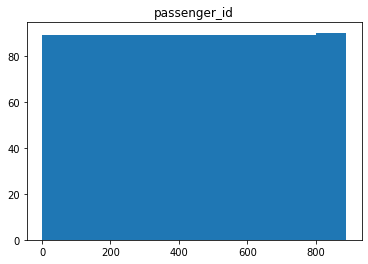

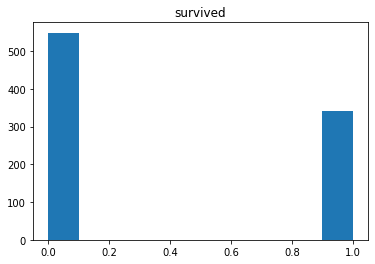

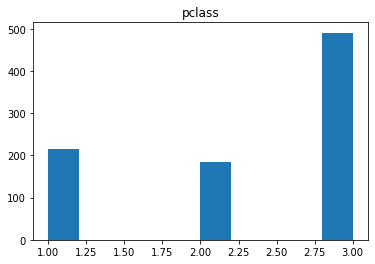

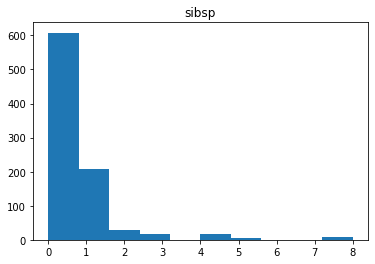

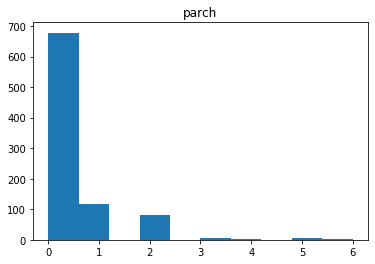

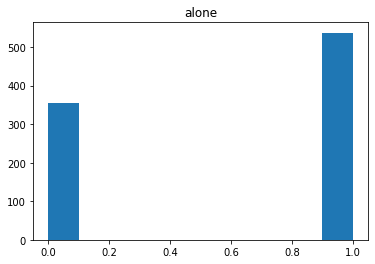

In [7]:
# Check out distributions of numeric columns.

num_cols = df.columns[[df[col].dtype == 'int64' for col in df.columns]]
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [8]:
# Use .describe with object columns.

obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]
for col in obj_cols:
    print(df[col].value_counts())
    print(df[col].value_counts(normalize=True, dropna=False))
    print('----------------------')

male      577
female    314
Name: sex, dtype: int64
male      0.647587
female    0.352413
Name: sex, dtype: float64
----------------------
S    644
C    168
Q     77
Name: embarked, dtype: int64
S      0.722783
C      0.188552
Q      0.086420
NaN    0.002245
Name: embarked, dtype: float64
----------------------
Third     491
First     216
Second    184
Name: class, dtype: int64
Third     0.551066
First     0.242424
Second    0.206510
Name: class, dtype: float64
----------------------
C    59
B    47
D    33
E    32
A    15
F    13
G     4
Name: deck, dtype: int64
NaN    0.772166
C      0.066218
B      0.052750
D      0.037037
E      0.035915
A      0.016835
F      0.014590
G      0.004489
Name: deck, dtype: float64
----------------------
Southampton    644
Cherbourg      168
Queenstown      77
Name: embark_town, dtype: int64
Southampton    0.722783
Cherbourg      0.188552
Queenstown     0.086420
NaN            0.002245
Name: embark_town, dtype: float64
----------------------


In [9]:
# Create bins for fare using .value_counts.
# Using sort = false will sort by bin values as opposed to the frequency counts.

df.fare.value_counts(bins=5, sort=False)

(-0.513, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(307.398, 409.863]      0
(409.863, 512.329]      3
Name: fare, dtype: int64

In [10]:
# Find columns with missing values and the total of missing values.

missing = df.isnull().sum()
missing[missing > 0]

age            177
embarked         2
deck           688
embark_town      2
dtype: int64

**Takeaways**
    
- embarked == embark_town, so remove embarked & keep embark_town   
- class == pclass, so remove class & keep pclass (already numeric)  
- drop deck...way too many missing values  
- fill embark_town with most common value ('Southampton')  
- drop age column  
- encode or create dummy vars for sex & embark_town. 

## Clean the Data

In [11]:
# Drop duplicates...run just in case; reassign and check the shape of my data.

df = df.drop_duplicates()
df.shape

(891, 13)

In [12]:
# Drop columns with too many missing values for now and reassign; check the shape of my data.

cols_to_drop = ['deck', 'embarked', 'class', 'age']
df = df.drop(columns=cols_to_drop)
df.shape

(891, 9)

In [13]:
# Validate that the columns are dropped.

df.head(1)

,passenger_id,survived,pclass,sex,sibsp,parch,fare,embark_town,alone
0,0,0,3,male,1,0,7.25,Southampton,0


We could fill `embark_town` with most common value, 'Southampton', by hard-coding the value using the fillna() function, as below. Or we could use an imputer. We will demonstrate the imputer *after* the train-validate-test split. 

In [14]:
# Run .fillna() on the entire df.

df['embark_town'] = df.embark_town.fillna(value='Southampton')

In [15]:
# Validate that missing values in embark_town have been handled.

df.embark_town.isna().sum()

0

Get dummy vars for sex and embark_town

- dummy_na: create a dummy var for na values, also?   
- drop_first: drop first dummy var (since we know if they do not belong to any of the vars listed, then they must belong to the first one that is not listed).   

In [16]:
# Using drop_first leaves sex_male, embark_town_Queenstown, and embark_town_Southampton.

dummy_df = pd.get_dummies(df[['sex','embark_town']], dummy_na=False, drop_first=[True, True])
dummy_df.head()

,sex_male,embark_town_Queenstown,embark_town_Southampton
0,1,0,1
1,0,0,0
2,0,0,1
3,0,0,1
4,1,0,1


In [17]:
# Concatenate the dummy_df dataframe above with the original df and validate.

df = pd.concat([df, dummy_df], axis=1)
df.head(1)

,passenger_id,survived,pclass,sex,sibsp,parch,fare,embark_town,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
0,0,0,3,male,1,0,7.25,Southampton,0,1,0,1


Create a function that will automate these steps for when we need to reproduce our process. 

In [18]:
def clean_data(df):
    '''
    This function will drop any duplicate observations, 
    drop ['deck', 'embarked', 'class', 'age'], fill missing embark_town with 'Southampton'
    and create dummy vars from sex and embark_town. 
    '''
    df = df.drop_duplicates()
    df = df.drop(columns=['deck', 'embarked', 'class', 'age'])
    df['embark_town'] = df.embark_town.fillna(value='Southampton')
    dummy_df = pd.get_dummies(df[['sex', 'embark_town']], drop_first=True)
    df = pd.concat([df, dummy_df], axis=1)
    return df

Acquire my data again to test my function below.

In [19]:
df = acquire.get_titanic_data()
df.head(2)

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0


In [20]:
df = clean_data(df)
df.head(2)

,passenger_id,survived,pclass,sex,sibsp,parch,fare,embark_town,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
0,0,0,3,male,1,0,7.2500,Southampton,0,1,0,1
1,1,1,1,female,1,0,71.2833,Cherbourg,0,0,0,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   passenger_id             891 non-null    int64  
 1   survived                 891 non-null    int64  
 2   pclass                   891 non-null    int64  
 3   sex                      891 non-null    object 
 4   sibsp                    891 non-null    int64  
 5   parch                    891 non-null    int64  
 6   fare                     891 non-null    float64
 7   embark_town              891 non-null    object 
 8   alone                    891 non-null    int64  
 9   sex_male                 891 non-null    uint8  
 10  embark_town_Queenstown   891 non-null    uint8  
 11  embark_town_Southampton  891 non-null    uint8  
dtypes: float64(1), int64(6), object(2), uint8(3)
memory usage: 72.2+ KB


## Split the Data

In [22]:
# 20% test, 80% train_validate
# then of the 80% train_validate: 30% validate, 70% train. 

train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.survived)
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train.survived)

In [23]:
# Validate my split.

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (498, 12)
validate -> (214, 12)
test -> (179, 12)


Create a function that will split my Titanic data into train, validate, and test DataFrames when I provide a DataFrame; it will stratify by `survived`, the categorical target variable. 

In [24]:
def split_data(df):
    '''
    take in a DataFrame and return train, validate, and test DataFrames; stratify on survived.
    return train, validate, test DataFrames.
    '''
    train_validate, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.survived)
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123, 
                                       stratify=train_validate.survived)
    return train, validate, test

Test out my function and validate my split.

In [25]:
train, validate, test = split_data(df)

In [26]:
# Validate my split

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (498, 12)
validate -> (214, 12)
test -> (179, 12)


## Impute Missing Values

We can impute values using the mean, median, mode (most frequent), or a constant value. We will use sklearn.imputer.SimpleImputer to do this.  

1. Create the imputer object, selecting the strategy used to impute (mean, median or mode (strategy = 'most_frequent'). 
2. Fit to train. This means compute the mean, median, or most_frequent (i.e. mode) for each of the columns that will be imputed. Store that value in the imputer object. 
3. Transform train: fill missing values in train dataset with that value identified
4. Transform test: fill missing values with that value identified

In [27]:
# Get fresh Titanic data to use with missing values in embark_town again.

df = acquire.get_titanic_data()
train, validate, test = split_data(df)

In [28]:
# ONLY look at train dataset after we split our data.

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 583 to 744
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passenger_id  498 non-null    int64  
 1   survived      498 non-null    int64  
 2   pclass        498 non-null    int64  
 3   sex           498 non-null    object 
 4   age           401 non-null    float64
 5   sibsp         498 non-null    int64  
 6   parch         498 non-null    int64  
 7   fare          498 non-null    float64
 8   embarked      497 non-null    object 
 9   class         498 non-null    object 
 10  deck          106 non-null    object 
 11  embark_town   497 non-null    object 
 12  alone         498 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 54.5+ KB


1. Create the `SimpleImputer` object, which we will store in the variable `imputer`. In the creation of the object, we will specify the strategy to use (`mean`, `median`, `most_frequent`). Essentially, this is creating the instructions and assigning them to a variable, `imputer`.  

In [29]:
imputer = SimpleImputer(missing_values = None, strategy='most_frequent')

2. `Fit` the imputer to the columns in the training df.  This means that the imputer will determine the `most_frequent` value, or other value depending on the `strategy` called, for each column.   

In [30]:
imputer = imputer.fit(train[['embark_town']])

3. It will store that value in the imputer object to use upon calling `transform.` We will call `transform` on our train, validate, and test datasets to fill any missing values.  

In [31]:
train[['embark_town']] = imputer.transform(train[['embark_town']])

validate[['embark_town']] = imputer.transform(validate[['embark_town']])

test[['embark_town']] = imputer.transform(test[['embark_town']])

In [32]:
# Validate that there are no longer any Null values in embark_town.

train.embark_town.value_counts(dropna=False)

Southampton    355
Cherbourg      102
Queenstown      41
Name: embark_town, dtype: int64

Create a function that will run through all of the steps above when I pass the train, validate, and test DataFrames as arguments. **My `clean_data()` function is already taking care of the missing values in `embark_town`, using `.fillna()` on the entire DataFrame. If I want to use this `impute_mode()` function, I could go back and tweak my `clean_data() function`, either/or but I don't need both.**

In [33]:
def impute_mode(train, validate, test):
    '''
    take in train, validate, and test DataFrames, impute mode for embark_town,
    and return train, validate, and test DataFrames
    '''
    imputer = SimpleImputer(missing_values = None, strategy='most_frequent')
    train[['embark_town']] = imputer.fit_transform(train[['embark_town']])
    validate[['embark_town']] = imputer.transform(validate[['embark_town']])
    test[['embark_town']] = imputer.transform(test[['embark_town']])
    return train, validate, test

Use our helper functions `clean_data()` and `split_data()` in our single `prep_titanic_data()` function that takes in my Titanic DataFrame and returns cleaned and split datasets with the mode value imputed for missing values in `embark_town`. 

In [38]:
# Acquire fresh Titanic data to test my funtion.

df = acquire.get_titanic_data()

In [35]:
def prep_titanic_data(df):
    '''
    This function takes in a df and will drop any duplicate observations, 
    drop ['deck', 'embarked', 'class', 'age'], fill missing embark_town with 'Southampton'
    create dummy vars from sex and embark_town, and perform a train, validate, test split. 
    Returns train, validate, and test DataFrames
    '''
    df = clean_data(df)
    train, validate, test = split_data(df)
    return train, validate, test

In [39]:
# Run final prepare function and validate what that the function is working properly.

train, validate, test = prep_titanic_data(df)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 583 to 744
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   passenger_id             498 non-null    int64  
 1   survived                 498 non-null    int64  
 2   pclass                   498 non-null    int64  
 3   sex                      498 non-null    object 
 4   sibsp                    498 non-null    int64  
 5   parch                    498 non-null    int64  
 6   fare                     498 non-null    float64
 7   embark_town              498 non-null    object 
 8   alone                    498 non-null    int64  
 9   sex_male                 498 non-null    uint8  
 10  embark_town_Queenstown   498 non-null    uint8  
 11  embark_town_Southampton  498 non-null    uint8  
dtypes: float64(1), int64(6), object(2), uint8(3)
memory usage: 40.4+ KB


___

## Exercises

The end product of this exercise should be the specified functions in a python script named `prepare.py`.
Do these in your `classification_exercises.ipynb` first, then transfer to the prepare.py file. 

This work should all be saved in your local `classification-exercises` repo. Then add, commit, and push your changes.

Using the Iris Data:  

1. Use the function defined in `acquire.py` to load the iris data.  

2. Drop the `species_id` and `measurement_id` columns.  

3. Rename the `species_name` column to just `species`.  

4. Create dummy variables of the species name and concatenate onto the iris dataframe. (This is for practice, we don't always have to encode the target, but if we used species as a feature, we would need to encode it).

5. Create a function named `prep_iris` that accepts the untransformed iris data, and returns the data with the transformations above applied.

Using the Titanic dataset

1. Use the function defined in `acquire.py` to load the Titanic data.  

2. Drop any unnecessary, unhelpful, or duplicated columns.

3. Encode the categorical columns. Create dummy variables of the categorical columns and concatenate them onto the dataframe.

4. Create a function named `prep_titanic` that accepts the raw titanic data, and returns the data with the transformations above applied.

Using the Telco dataset

1. Use the function defined in `acquire.py` to load the Telco data.  

2. Drop any unnecessary, unhelpful, or duplicated columns. This could mean dropping foreign key columns but keeping the corresponding string values, for example.

3. Encode the categorical columns. Create dummy variables of the categorical columns and concatenate them onto the dataframe.

4. Create a function named `prep_telco` that accepts the raw telco data, and returns the data with the transformations above applied.
